## Modules

In [1]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
!apt-get install -y graphviz-dev
!pip install pygraphviz
import networkx as nx
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 24 not upgraded.
Need to get 2,148 kB of archives.
After this operation, 7,427 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-common all 2.24.32-4ubuntu4 [126 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-0 amd64 2.24.32-4ubuntu4 [1,791 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libgail18 amd64 2.24.32-4ubuntu4 [14.7 kB]
Get:4 http://archive.ubuntu.

## Importing Data

In [2]:
# Import from github
url = "https://raw.githubusercontent.com/JRickey/Vasicek_Project/main/Data_Vasicek_Project.csv"
data = pd.read_csv(url)
print(data)

# Import from google drive
#data = pd.read_csv('/content/drive/MyDrive/BUFN744 SVB Report/Data_Vasicek_Project.csv')

        Date    Close  Unnamed: 2  Unnamed: 3
0   12/31/95  0.99407         NaN         NaN
1    1/31/96  0.99510         NaN         NaN
2    2/29/96  0.99478         NaN         NaN
3    3/31/96  0.99488         NaN         NaN
4    4/30/96  0.99483         NaN         NaN
..       ...      ...         ...         ...
79   7/31/02  0.99831         NaN         NaN
80   8/31/02  0.99824         NaN         NaN
81   9/30/02  0.99825         NaN         NaN
82  10/31/02  0.99841         NaN         NaN
83  11/30/02  0.99863         NaN         NaN

[84 rows x 4 columns]


## Formatting Data

In [3]:
data.columns = ['Date', 'Close','Lag','Int']
data['Close'] = -np.log(data['Close'])*12
data['Lag'] = data['Close'].shift(1)
data = data.drop(index = 0)
data['Int'] = [1]*len(data)
print(data)

        Date     Close       Lag  Int
1    1/31/96  0.058945  0.071372    1
2    2/29/96  0.062804  0.058945    1
3    3/31/96  0.061598  0.062804    1
4    4/30/96  0.062201  0.061598    1
5    5/31/96  0.060271  0.062201    1
..       ...       ...       ...  ...
79   7/31/02  0.020297  0.021259    1
80   8/31/02  0.021139  0.020297    1
81   9/30/02  0.021018  0.021139    1
82  10/31/02  0.019095  0.021018    1
83  11/30/02  0.016451  0.019095    1

[83 rows x 4 columns]


## Run Regression

In [4]:
exog = data['Lag']
exog = sm.add_constant(exog, prepend=True)
mod = sm.OLS(data['Close'], exog)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     809.8
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           6.22e-44
Time:                        23:38:47   Log-Likelihood:                 317.10
No. Observations:                  83   AIC:                            -630.2
Df Residuals:                      81   BIC:                            -625.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.002      0.257      0.7

## Estimate Parameters

In [5]:
beta1 = res.params[1]
beta0 = res.params[0]
error = res.bse[1]

phi = beta1
mu = beta0/(1-beta1)
sigma = np.sqrt(error**2/(1-beta1**2))

print('beta0 is', beta0)
print('beta1 is', beta1)
print('error is', error)
print('Our estimate of Phi is', beta1)
print('Our estimate of Mu is', mu)
print('Our estimate of Sigma is',sigma)

beta0 is 0.0005194276560930022
beta1 is 0.9790175795373756
error is 0.03440315317004547
Our estimate of Phi is 0.9790175795373756
Our estimate of Mu is 0.02475537352891427
Our estimate of Sigma is 0.16882844881943898


## Code to construct Binomial Tree

In [6]:
class binomialTree:
  def __init__(self, rate, probability):
    self.rate = rate
    self.probability = probability
    self.nodes = []

  def add_node(self, node):
    self.nodes.append(node)

  def __repr__(self):
    return f"Rate {self.rate}, Probability {self.probability}"

## Compute Step Size and QV

In [7]:
step = sigma*np.sqrt(-2*np.log(phi))*np.sqrt(1/12)
print('Step is equal to', step)

def qvt(r):
  return 0.5 + (mu - r)*np.sqrt(1/12)*np.sqrt(-np.log(phi))/(sigma*np.sqrt(8))

Step is equal to 0.010036819330832943


## Construct Vasicek Tree

In [8]:
# Starting tree at 11/30/2002
root = binomialTree(rate = data.loc[83,'Close'], probability = 1)

#Adding up node for t + h 
up1 = binomialTree(rate = root.rate + step, probability = qvt(root.rate))
root.add_node(up1)

#Adding down node for t + h
down1 = binomialTree(rate = root.rate - step, probability = 1-qvt(root.rate))
root.add_node(down1)

#Adding up up node for t + 2h
upup2 = binomialTree(rate = up1.rate + step, probability = qvt(up1.rate))
up1.add_node(upup2)

#Adding up down node for t + 2h
updown2 = binomialTree(rate = up1.rate - step, probability = 1-qvt(up1.rate))
up1.add_node(updown2)

#Adding down up node for t + 2h
downup2 = binomialTree(rate = down1.rate + step, probability = qvt(down1.rate))
down1.add_node(downup2)

#Adding down down node for t + 2h
downdown2 = binomialTree(rate = down1.rate - step, probability = 1-qvt(down1.rate))
down1.add_node(downdown2)

print('Root of the tree is:', root)
print('Period 1 nodes are:', root.nodes)
print('Period 2 up nodes are:', up1.nodes)
print('Period 2 down nodes are:', down1.nodes)

Root of the tree is: Rate 0.016451271695991643, Probability 1
Period 1 nodes are: [Rate 0.026488091026824586, Probability 0.5007310339072498, Rate 0.0064144523651586995, Probability 0.4992689660927502]
Period 2 up nodes are: [Rate 0.03652491035765753, Probability 0.49984746390782014, Rate 0.016451271695991643, Probability 0.5001525360921799]
Period 2 down nodes are: [Rate 0.016451271695991643, Probability 0.5016146039066796, Rate -0.003622366965674244, Probability 0.49838539609332044]


## Plot Tree

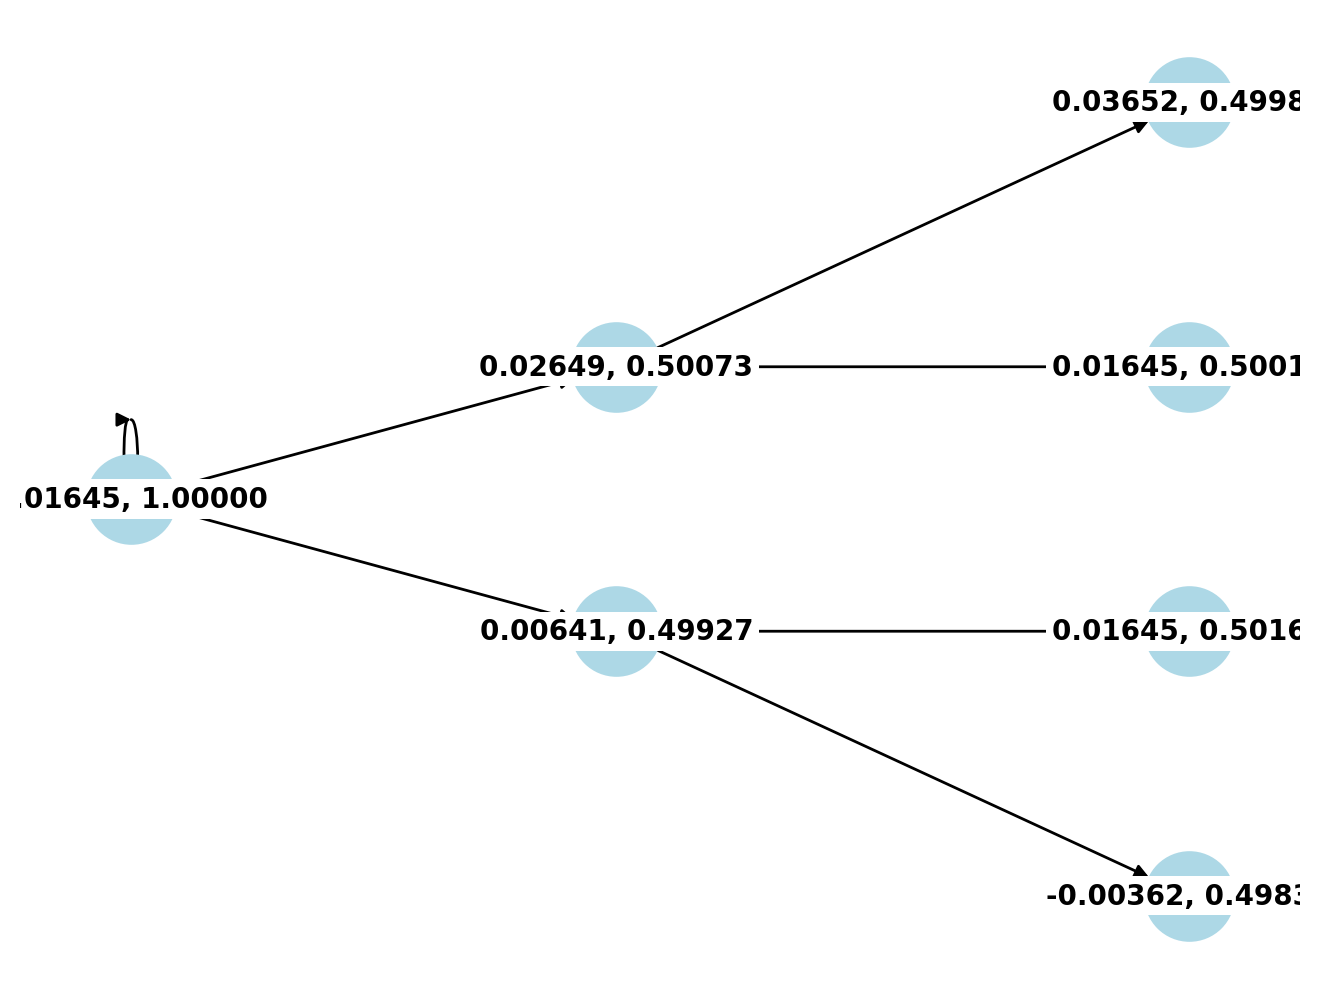

In [9]:
def build_edges_binomial(tree, parent=None, is_root=True):
    edges = []
    
    # Include the root node
    if is_root:
        tree_node = binomialTree(tree.rate, tree.probability)
        tree.nodes.append(tree_node)
        parent = tree_node
        is_root = False
    
    for node in tree.nodes:
        if parent is not None and not is_root:
            edges.append((parent, node))
        edges.extend(build_edges_binomial(node, parent=node, is_root=is_root))
    
    return edges


def plot_tree_binomial(tree):
    edges = build_edges_binomial(tree)
    graph = nx.DiGraph()
    graph.add_edges_from(edges)

    graph.graph['graph'] = {'rankdir': 'LR'}

    pos = nx.drawing.nx_agraph.graphviz_layout(graph, prog="dot")
    nx.draw(graph, pos, with_labels=False, arrows=True, node_color='lightblue', node_size=1000)
    
    labels = {node: f"{node.rate:.5f}, {node.probability:.5f}" for node in graph.nodes}
    nx.draw_networkx_labels(graph, pos, labels, font_size=10, font_weight='bold', bbox=dict(facecolor='white', edgecolor='none', pad=2))

    plt.show()
    

plot_tree_binomial(root)